In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

%matplotlib inline

# Problem 1: Call Center Modelling

As we're rehashing code from class, I've removed docstrings to make this submission less volumnious/easier to parse. Added comments in places to demonstrate understanding, if needed. 

In [2]:
waiting_times_day = np.loadtxt(
    'https://course-resources.minerva.kgi.edu/uploaded_files/mke/'
    '00124343-8397/call-center.csv')
waiting_times_per_hour = [[] for _ in range(24)]

current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

In [3]:
def prior(lambda_):
    return sts.gamma(1, scale = 1/0.25).pdf(lambda_)

def likelihood(lambda_, datum):
    return sts.expon(scale = 1/lambda_).pdf(datum)

def compute_posterior(parameter_values, prior, likelihood, data):
    # Take log to ease computations
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    
    # Unnormed log posterior
    unnormalized_log_posterior = log_prior + log_likelihood
    # Rescale
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    # Normalize
    posterior = unnormalized_posterior / area
    return posterior

hour_index = 9
waiting_times_hour = waiting_times_per_hour[hour_index]

lambdas = np.linspace(0, 10, 501)[1:]
posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

## Recall

In class, we updated our prior on the number of calls per minute (lambda) based on data from the 'call-center.csv' data set. Crucially, this data is for just one hour specified by the 'hour_index' variable. 

To make inferences for each hour of the day, we need to loop through data for each hour of the day and compute and record the posterior means for each hour. Confidence-interval computations are handled by the following compute_percentile function, which spotlights the desired 98% width percentiles (0.1, 0.99) over the posterior's cdf. The expected value and confidence interval are returned by compute_inferences, which wraps the aforementioned 

In [4]:
def compute_percentile(parameter_values, distribution_values, percentile):
    ''' Returns (mean, 98% [0.01, 0.99] CI) on posterior:array-like distribution of calls/min.'''
    cumulative_distribution = sp.integrate.cumtrapz(distribution_values, 
                                                    parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution,
                                       percentile)

    return lambdas[percentile_index]


def compute_inferences(lambdas, posterior):
    '''Returns a tuple of expected value, 98% CI for plotting. Expensive, 
       but we aren't working with conjugate priors here.'''
    conf_int = [compute_percentile(lambdas, posterior, p) 
                for p  
                in [0.01, 0.99]]
    exp_val = sp.integrate.trapz(posterior * lambdas, lambdas)

    return (exp_val, [exp_val  - conf_int[0], conf_int[1] - exp_val])

point = compute_inferences(lambdas, posterior)

Before we complete the modeling, we pause to check that compute_inferences works as desired below.
This might be pedantic, but the error widths (distance between expected value and respective confidence interval bound) are non-identical. More than suggesting an asymmetric posterior, the yerr keyword in plt.errorbar specifies symmetric errors by default. So we need to do some transformation to the confidence interval arrays before plotting. 

(Note: they are *almost* symmetric, but I'm a stickler for this stuff)

In [5]:
print(f"Point: mean = {point[0]}",
      f"yerr_lower = {point[1][0]}", 
      f"y_err_upper = {point[1][1]}")

Point: mean = 5.728695915357027 yerr_lower = 0.7086959153570263 y_err_upper = 0.7313040846429733


For each hour of the day, we can now infer the unknown parameter of interest - call rate - by updating a prior with data on calls per hour, encoded as an exponential likelihood function. 

The beta prior is a kind of easygoing, conservative distribution. For it to reflect broader presumptions about reality, we elongate its support from [0,10] to [0,20] calls per minute, given the observation we made in PCW that calls tend to pick up around noon (perhaps because lots of people are awake, idle enough during a lunch break to make a call, or some other propensity in the broader population).  

In [6]:
data = []
for hour in range(24):
    current_hour = waiting_times_per_hour[hour]

    lambdas = np.linspace(0, 20, 501)[1:]
    posterior = compute_posterior(lambdas, prior, likelihood, current_hour)

    data.append((hour + 1, compute_inferences(lambdas, posterior)))

Mean expected call rate over the day is 4.07 per min


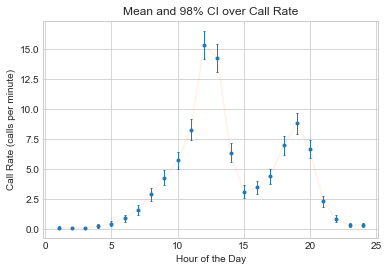

In [7]:
# Transpose data
plot_data = list(zip(*data))

t = plot_data[0]
y = [i[0] for i in plot_data[1]]
yerr = [i[1] for i in plot_data[1]]
# Parse for asymmetric errors
yerr = np.transpose(yerr)

plt.errorbar(t,y, yerr = yerr, fmt = '.', capsize = 1, elinewidth = 1)
plt.plot(t,y, alpha = 0.1)
plt.title("Mean and 98% CI over Call Rate")
plt.xlabel("Hour of the Day")
plt.ylabel("Call Rate (calls per minute)")

print(f"Mean expected call rate over the day is", 
      f"{round(np.mean(y), 2)} per min")

This plot is an instructive example on why I love Bayesian statistics. We have a layperson with a decision problem  - a white-collar call center manager figuring out how to staff agents - without the luxury of lots of trials. With a reasonable prior and moderate amounts of call data, we can tell him what to expect, and what to be surprised by. This is what I would say:

"The graph, which summarizes inferred call rates over the course of each hour of the day, suggests that the you should expect two surges, peaking first and strongly at 12 - 1 pm with about 16 calls/min and then moderately at 7 pm with 8 calls/min. These are *expected* rates, which implies that there will be some variation around it. The variation around it that *should not* surprise you is captured by the error bars overlapping each point. For example, at 12 pm expect 16 calls/min, but be surprised by anything less than about 13 and greater than 17 calls a minute. 

4 calls a minute, the average of these expected values, forms a yardstick for how busy the center is over the course of the day: your busy hours are between 9 AM and a little after 8 PM, while quiet hours are between 8 PM and 5 AM. 

Interestingly, there is very little variation during these quiet hours, which suggests that you can safely staff more minimally. On the other hand, the higher variation during busy hours suggests you may want to overstaff, or have additional staff on call. Without data on service times, I cannot provide more precise information. Though a similar analysis will prove fruitful."

# Problem 2: Bent Coin Inference

We are deriving our likelihood function from a series of Bernoulli trials in which a bent coin comes up heads 6 times and tails 16 times, with a probability (\pi) that it comes up head. 

A prior is a distribution over this unknown probability (\pi), though semantically we'd prefer to call it a *bias*. We've never seen the coin, and we don't know if particular biases are favorable, or not. So electing for a uniform prior is a safe bet, as we aren't letting our data (6/20) influence the fact that extreme biases (0.9) are as likely as moderate ones (0.3). 

In the interest of making updates easy, we represent the uniform distribution as a special case of the beta distribution, which conjugate to the binomial likelihood. The posterior will just be a beta with hyperparameters "nudged" by data, the nudge being nice closed-form expressions.  

Expected value for pi : 0.3181818181818182
95% CI : [0.14587694234309673,0.5217511182471137]


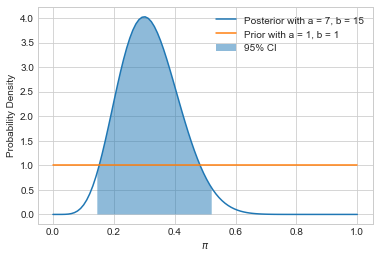

In [8]:
def prior(a,b):
    return sts.beta(a, b)

def posterior(a, b):
    k = 6
    n = 20

    a_1 = a + k
    b_1 = b + n - k 

    dist = sts.beta(a_1, b_1)

    x = np.linspace(0,1, 100)
    post = dist.pdf(x)
    pr = prior(a,b).pdf(x)

    lower = dist.ppf(0.025)
    upper = dist.ppf(0.975)

    x_int = np.linspace(lower, upper, 1000)

    print(f'Expected value for pi : {dist.mean()}')
    print(f'95% CI : [{lower},{upper}]')

    plt.plot(x,post, label = f'Posterior with a = {a_1}, b = {b_1}')
    plt.plot(x, pr, label = f"Prior with a = {a}, b = {b}")
    plt.fill_between(x_int, dist.pdf(x_int), alpha = 0.5, label = "95% CI")
    plt.xlabel("$\pi$")
    plt.ylabel("Probability Density")
    plt.legend()

    return dist

d = posterior(1, 1)

Head favorability is equivalent to asking p(pi) > 0.5, or, the area under the posterior from pi till 1. Since we have a parametric distribution, we can just use the inverse cdf. Given the upper bound CI of 0.52, I expect this to be around ~0.03:

In [9]:
print(f'Head bias is {1 - d.cdf(0.5)}')

Head bias is 0.03917694091796875


Sure enough, there's a very slim chance (3.9%) that the coin is biased towards heads, conditioned on this data. There might be some underlying data generating process too that we're unaware about that might "switch off" and adjust out predictions. Luckily, conjugate pairs make recomputing this easy. 